In [1]:
import ast
import collections
import functools
import json
import math
import os
import re
import sys
import time
from collections import deque, defaultdict
from functools import partial

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import display
from torch.autograd import grad
from torch.autograd.functional import hessian, jacobian
from torch.func import jacrev, vmap
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, parent_dir)

from src.dataloader import FastTensorDataLoader

In [2]:
torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data Preparation

In [3]:
def parse_filename(filename):
    if "sftcr" in filename:
        process_type = "sftcr"
        pattern = r'kappa([0-9.]+)_sigma([0-9.]+)'
    elif "lj" in filename:
        process_type = "lj"
        pattern = r'epsilon([0-9.]+)_sigma([0-9.]+)'
    else:
        process_type = None
        pattern = None

    kappa_or_epsilon = None
    sigma = None
    if pattern:
        match = re.search(pattern, filename)
        if match:
            kappa_or_epsilon = torch.tensor(float(match.group(1)))
            sigma = torch.tensor(float(match.group(2)))

    if "inhom" in filename:
        homogeneous = False
    elif "hom" in filename:
        homogeneous = True
    else:
        homogeneous = None

    return kappa_or_epsilon, sigma, homogeneous, process_type

In [4]:
files = [
    "simulations/simulated_points_sftcr_kappa0.5_sigma0.05_inhom.csv",
    "simulations/simulated_points_sftcr_kappa0.5_sigma0.15_inhom.csv",
    "simulations/simulated_points_sftcr_kappa0.5_sigma0.01_hom.csv",
    "simulations/simulated_points_sftcr_kappa0.5_sigma0.025_hom.csv",
    "simulations/simulated_points_sftcr_kappa0.5_sigma0.05_hom.csv",
    "simulations/simulated_points_sftcr_kappa0.5_sigma0.075_hom.csv",
    "simulations/simulated_points_sftcr_kappa0.5_sigma0.1_hom.csv",
    "simulations/simulated_points_sftcr_kappa0.5_sigma0.125_hom.csv",
    "simulations/simulated_points_sftcr_kappa0.5_sigma0.15_hom.csv",
    "simulations/simulated_points_sftcr_kappa0.5_sigma0.15_hom_larger_window.csv",
    "simulations/simulated_points_lj_epsilon0.1_sigma0.15_hom.csv",
    "simulations/simulated_points_lj_epsilon0.1_sigma0.15_inhom.csv"
]

file_selector = widgets.Dropdown(
    options=files,
    value=files[6],  # default
    description='Dataset:',
    layout=widgets.Layout(width='80%')
)

selected_filename = {"value": file_selector.value}

def on_file_change(change):
    if change["name"] == "value":
        selected_filename["value"] = change["new"]
        print(f"Selected file: {selected_filename['value']}")

file_selector.observe(on_file_change, names='value')
display(file_selector)

Dropdown(description='Dataset:', index=6, layout=Layout(width='80%'), options=('simulations/simulated_points_s…

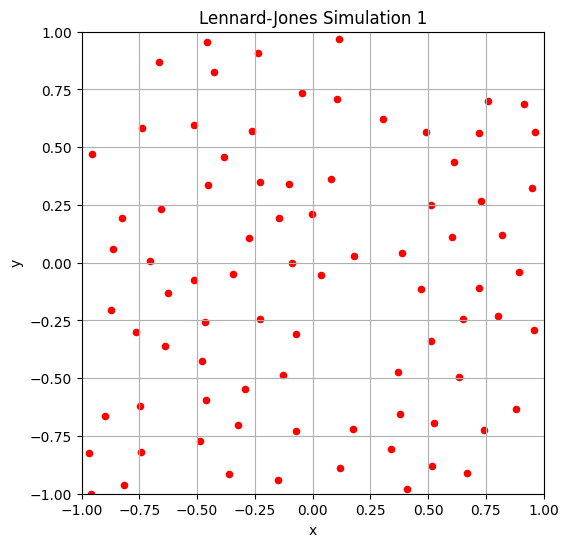

In [5]:
filename = selected_filename["value"]
df = pd.read_csv(filename)
parameter, sigma, homogeneous, process = parse_filename(filename)

if process == "sftcr":
    k = parameter.clone()
else:
    epsilon = parameter.clone()
scale = torch.tensor(0.5)

samples = [
    torch.tensor(group[["x", "y"]].values, dtype=torch.float32, device=device) 
    for _, group in df.groupby("sim")
]
samples = tuple(samples)[:10]
sim1 = samples[0].cpu()

plt.figure(figsize=(6, 6))
plt.scatter(sim1[:, 0], sim1[:, 1], color="red", s=20)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Softcore Simulation 1" if process == "sftcr" else "Lennard-Jones Simulation 1")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal")
plt.grid(True)
plt.show()

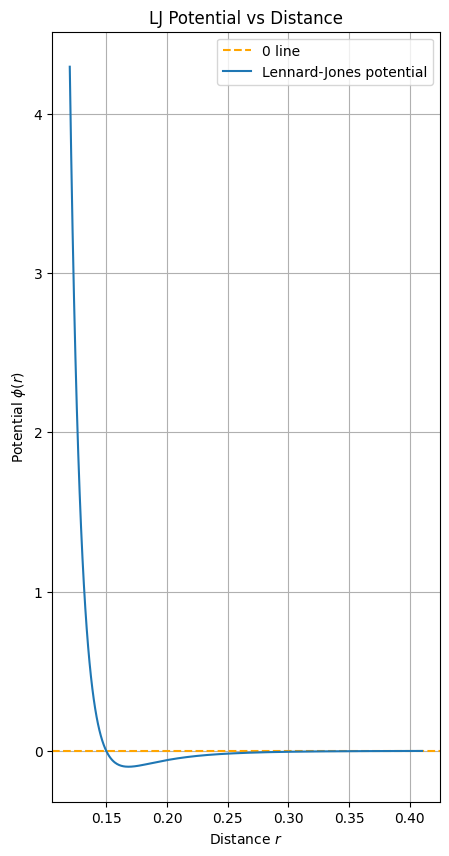

In [6]:
if process == "lj":
    r = torch.linspace(0.12, 0.41, 500)
    phi = 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)        
    
    plt.figure(figsize=(5, 10))
    plt.axhline(y=0, color="orange", linestyle="--", label="0 line")
    plt.plot(r.numpy(), phi.numpy(), label="Lennard-Jones potential")
    plt.title("LJ Potential vs Distance")
else:
    r = torch.linspace(0.01, 0.5, 500)
    phi = (sigma / r) ** (2 / k)

    
    plt.figure(figsize=(8, 5))
    plt.axhline(y=1e-5, color="orange", linestyle="--", label="~0 line")
    plt.title("Softcore Potential vs Distance")
    plt.plot(r.numpy(), phi.numpy(), label="Softcore potential")
    plt.yscale("log")

plt.xlabel("Distance $r$")
plt.ylabel("Potential $\\phi(r)$")
plt.grid(True)
plt.legend()
plt.show()

### Data Loader

In [7]:
test_size_widget = widgets.FloatSlider(
    value=0.2,
    min=0.0,
    max=0.9,
    step=0.05,
    description='Test size:',
    continuous_update=False,
    readout_format='.2f'
)

batch_size_widget = widgets.IntSlider(
    value=32,
    min=1,
    max=512,
    step=1,
    description='Batch size:',
    continuous_update=False
)

display(test_size_widget, batch_size_widget)

# Global storage
saved_params = {
    "test_size": test_size_widget.value,
    "batch_size": batch_size_widget.value,
    "loader_train": None,
    "loader_test": None
}

# Update function
def on_widget_change(change):
    if change["name"] == "value":
        saved_params["test_size"] = test_size_widget.value
        saved_params["batch_size"] = batch_size_widget.value

        train_ratio = 1 - saved_params["test_size"]
        
        X = pad_sequence(samples, batch_first=True, padding_value=0)
        lengths = torch.tensor([len(s) for s in samples], dtype=torch.int64, device=device)
        lengths_expanded = lengths.unsqueeze(-1).expand(-1, X.shape[1])
        X = torch.cat((X, lengths_expanded.unsqueeze(-1)), dim=-1)

        m = len(X)
        train_size = int(train_ratio * m)
        X_train = X[:train_size]
        X_test = X[train_size:]

        loader_train = FastTensorDataLoader(X_train, batch_size=saved_params["batch_size"], shuffle=False)
        loader_test = FastTensorDataLoader(X_test, batch_size=saved_params["batch_size"], shuffle=False)

        saved_params["loader_train"] = loader_train
        saved_params["loader_test"] = loader_test

        print(f"[Updated] Train size: {len(X_train)}, Test size: {len(X_test)}, Batch size: {saved_params['batch_size']}")

# Attach observers
test_size_widget.observe(on_widget_change, names="value")
batch_size_widget.observe(on_widget_change, names="value")


FloatSlider(value=0.2, continuous_update=False, description='Test size:', max=0.9, step=0.05)

IntSlider(value=32, continuous_update=False, description='Batch size:', max=512, min=1)

In [8]:
loader_train = saved_params["loader_train"]
loader_test = saved_params["loader_test"]
batch_size = saved_params["batch_size"]
test_size = saved_params["test_size"]

## Model

### Optimization function

In [9]:
def optimize_theta(
    loader_train, nn_model,
    num_epochs=1000, learning_rate=1e-3, K=None,
    homogeneous=True, canonical=False, initial_sigma=None,
):
    model = nn_model(homogeneous, canonical, K=K, initial_sigma=initial_sigma)
    model = model.double()

    optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate, step_sizes=(1e-06, 50))

    avg_epoch_losses = []
    avg_epoch_real_losses = []
    param_history = {}

    pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")
    for epoch in pbar:
        epoch_loss_sum = 0
        epoch_real_loss_sum = 0
        num_batches = len(loader_train)

        batch_param_values = {}
        start_time = time.time()

        for X_batch in loader_train:
            x = X_batch[0]
            x = x.double()
            x.requires_grad_()

            optimizer.zero_grad()
            loss, real_loss = model.loss(x)
            loss.backward()
            optimizer.step()

            epoch_loss_sum += loss.item()
            epoch_real_loss_sum += real_loss.item()

            for name, param in model.named_parameters():
                if param.requires_grad:
                    value = param.detach().cpu().numpy().copy()
                    batch_param_values.setdefault(name, []).append(value)

        avg_loss = epoch_loss_sum / num_batches
        avg_real_loss = epoch_real_loss_sum / num_batches
        avg_epoch_losses.append(avg_loss)
        avg_epoch_real_losses.append(avg_real_loss)

        for name, values in batch_param_values.items():
            avg_value = sum(values) / len(values)
            param_history.setdefault(name, []).append(avg_value)

        elapsed_time = time.time() - start_time
        postfix = {
            "Train Loss": f"{avg_loss:.4f}",
            "Real Loss": f"{avg_real_loss:.4f}",
            "Time/Epoch": f"{elapsed_time:.2f}s",
        }
        pbar.set_postfix(postfix)

    return {
        "model": model,
        "avg_epoch_losses": avg_epoch_losses,
        "avg_epoch_real_losses": avg_epoch_real_losses,
        "param_history": param_history,
    }

In [10]:
class Gibbs(nn.Module):
    def __init__(self, homogeneous=True, canonical=False, K=None, initial_sigma=None, compare_analytical=True):
        super().__init__()
        torch.manual_seed(123)
        torch.cuda.manual_seed(123)

        self.homogeneous = homogeneous
        self.canonical = canonical
        self.compare_analytical = compare_analytical
        self.K = K
        
        if not self.homogeneous:
            self.scale_raw = nn.Parameter(torch.log(torch.rand(1, device=device)))
        
        if self.canonical:
            epsilon_raw = torch.log(torch.rand(1, device=device))
            sigma_raw = torch.log(torch.tensor([initial_sigma], device=device))
            self.sigma0 = initial_sigma
        
            sigma = torch.exp(sigma_raw)
            epsilon = torch.exp(epsilon_raw)
            ratio = sigma / self.sigma0
        
            self.theta1 = nn.Parameter(4 * epsilon * ratio**12)
            self.theta2 = nn.Parameter(4 * epsilon * ratio**6)
        else:  
            self.sigma_raw = nn.Parameter(torch.log(torch.tensor([initial_sigma], device=device)))
            self.epsilon_raw = nn.Parameter(torch.log(torch.rand(1, device=device)))
                
    @property
    def epsilon(self):
        return torch.exp(self.epsilon_raw)

    @property
    def sigma(self):
        return torch.exp(self.sigma_raw)

    @property
    def scale(self):
        return torch.exp(self.scale_raw)

    def forward(self, x, mask):
        _, N, _ = x.shape
        i_idx, j_idx = torch.triu_indices(N, N, offset=1, device=x.device)

        xi, xj = x[:, i_idx, :], x[:, j_idx, :]
        diff = xi - xj
        r2 = (diff ** 2).sum(dim=-1).clamp(min=1e-10)
        r = torch.sqrt(r2)

        mask_i, mask_j = mask[:, i_idx], mask[:, j_idx]
        pairwise_mask = mask_i & mask_j
        
        phi = torch.zeros_like(r)
        if self.canonical:
            sigma0_r = (self.sigma0 / r[pairwise_mask])**6
            phi[pairwise_mask] =  self.theta1 * sigma0_r**2 - self.theta2 * sigma0_r
        else:
            sigma_r = (self.sigma / r[pairwise_mask])**6
            phi[pairwise_mask] = 4 * self.epsilon * (sigma_r**2 - sigma_r)

        energy = phi.sum(dim=-1)
        if self.homogeneous:
            return -energy
        return -x.pow(2).sum(dim=-1).sum(dim=-1) / self.scale**2 - energy

    def compute_psi(self, x, mask):
        output = self.forward(x, mask)
        grad_outputs = torch.ones_like(output)
        return torch.autograd.grad(
            output, x, grad_outputs=grad_outputs,
            retain_graph=True, create_graph=True,
        )[0]
    
    def lennard_jones_psi(self, x, mask):
        _, N, _ = x.shape
        i_idx, j_idx = torch.triu_indices(N, N, offset=1, device=x.device)
    
        xi, xj = x[:, i_idx, :], x[:, j_idx, :]
        diff = xi - xj
        r2 = (diff ** 2).sum(dim=-1).clamp(min=1e-10)
        r = torch.sqrt(r2)
    
        mask_i, mask_j = mask[:, i_idx], mask[:, j_idx]
        pairwise_mask = mask_i & mask_j
            
        inv_r = 1.0 / r[pairwise_mask]
        if self.canonical:
            sigma0 = self.sigma0
            inv_r6 = sigma0 ** 6 * inv_r ** 7
            inv_r12 =  sigma0 ** 12 * inv_r ** 13
            coeff = (-12 * self.theta1 * inv_r12 + 6 * self.theta2 * inv_r6) * inv_r
        else:
            inv_r6 = self.sigma ** 6 * inv_r ** 7
            inv_r12 = self.sigma ** 12 * inv_r ** 13
            coeff = 4 * self.epsilon * (-12 * inv_r12 + 6 * inv_r6) * inv_r
        
        grad = torch.zeros_like(diff)
        grad[pairwise_mask] = coeff.unsqueeze(-1) * diff[pairwise_mask]
    
        force = torch.zeros_like(x)
        force.index_add_(1, i_idx, grad)
        force.index_add_(1, j_idx, -grad)

        if self.homogeneous:
            return -force
        return -2 * x / self.scale**2 - force

    def J(self, x, mask):
        B, N, D = x.shape
        i_idx, j_idx = torch.triu_indices(N, N, offset=1, device=x.device)
    
        psi_x = self.lennard_jones_psi(x, mask)
        norm_squared = psi_x.pow(2).sum(dim=-1)
    
        xi, xj = x[:, i_idx, :], x[:, j_idx, :]
        diff = xi - xj
        r2 = (diff ** 2).sum(dim=-1).clamp(min=1e-10)
    
        mask_i, mask_j = mask[:, i_idx], mask[:, j_idx]
        pairwise_mask = mask_i & mask_j  # (B, K)
    
        diff_outer = diff.unsqueeze(-1) @ diff.unsqueeze(-2)
        I = torch.eye(D, device=x.device).view(1, 1, D, D)
    
        term = torch.zeros_like(diff_outer)
        valid_mask = pairwise_mask
    
        d_outer = diff_outer[valid_mask]
        r2v = r2[valid_mask].unsqueeze(-1).unsqueeze(-1)
    
        if self.canonical:
            sigma0 = self.sigma0
            sigma0_6 = sigma0 ** 6
            sigma0_12 = sigma0_6 ** 2
            LJ_matrix = -(
                -12 * self.theta1 * sigma0_12 * (I / r2v**7 - 14 * d_outer / r2v**8) +
                 6 * self.theta2 * sigma0_6 * (I / r2v**4 -  8 * d_outer / r2v**5)
            )
        else:
            sigma6 = self.sigma ** 6
            sigma12 = sigma6 ** 2
            LJ_matrix = -4 * self.epsilon * (
                -12 * sigma12 * (I / r2v**7 - 14 * d_outer / r2v**8) +
                 6 * sigma6  * (I / r2v**4 -  8 * d_outer / r2v**5)
            )
    
        term[valid_mask] = LJ_matrix
        div_phi = term.diagonal(dim1=-2, dim2=-1).sum(-1)  # (B, K)
        div_phi[~pairwise_mask] = 0
    
        interaction_div = torch.zeros(B, N, device=x.device)
        for idx in (i_idx, j_idx):
            interaction_div.index_add_(1, idx, div_phi)
    
        if self.homogeneous:
            divergence = interaction_div
        else:
            divergence = -2 / self.scale**2 * D + interaction_div
    
        return divergence, norm_squared
        
    def loss(self, points):
        lengths = points[:, 0, -1].to(dtype=torch.int64, device=device)
        max_length = lengths.max()
        x_t = points[:, :max_length, :-1]
        mask = torch.arange(max_length, device=device).unsqueeze(0) < lengths.unsqueeze(1)

        psi_x = self.compute_psi(x_t, mask)
        if self.compare_analytical: 
            psi_x_real = self.lennard_jones_psi(x_t, mask)

        norm_squared = psi_x.pow(2).sum(dim=-1) * mask

        if self.K:
            divergence = 0
            for _ in range(self.K):
                epsilon = torch.randint(0, 2, x_t.shape, device=device).float() * 2 - 1
                eps_psi = (psi_x * epsilon).sum()
                divergence_est = torch.autograd.grad(
                    eps_psi, x_t, create_graph=True
                )[0]
                divergence += (divergence_est * epsilon).sum(dim=-1) 
            divergence = (divergence / self.K) * mask
        else:
            divergence = torch.zeros(x_t.shape[0], x_t.shape[1], device=x_t.device)
            for d in range(x_t.shape[-1]):
                for i in range(x_t.shape[-2]):
                    second_grad = torch.autograd.grad(
                        psi_x[:, i, d].sum(), x_t, retain_graph=True, create_graph=True
                    )[0][:, i, d]
                    divergence[:, i] += second_grad
            divergence = divergence * mask

        if self.compare_analytical: 
            divergence_real, norm_squared_real = self.J(x_t, mask)
            divergence_real *= mask
            norm_squared_real *= mask

        total_loss = (0.5 * norm_squared + divergence).sum(dim=-1) / lengths
        J = (0.5 * norm_squared_real + divergence_real).sum(dim=-1) / lengths if self.compare_analytical else torch.tensor([0.0])
        return total_loss.mean(), J.mean()

In [11]:
class Gibbs_Softcore(nn.Module):
    def __init__(self, homogeneous=True, canonical=False, fixed_k=0.5, K=None, initial_sigma=None, compare_analytical=True):
        super().__init__()
        torch.manual_seed(123)
        torch.cuda.manual_seed(123)

        self.homogeneous = homogeneous
        self.canonical = canonical
        self.compare_analytical = compare_analytical
        self.fixed_k = fixed_k
        self.K = K

        if not self.homogeneous:
            self.scale_raw = nn.Parameter(torch.log(torch.rand(1, device=device)))

        if canonical:
            sigma_raw = torch.tensor([initial_sigma], device=device)
            self.gamma = nn.Parameter(sigma_raw**(2/k))
        else:
            self.sigma_raw = nn.Parameter(torch.log(torch.tensor([initial_sigma], device=device)))
            self.k_raw = nn.Parameter(torch.rand(1, device=device))

    @property
    def scale(self):
        return torch.exp(self.scale_raw)

    @property
    def sigma(self):
        return torch.exp(self.sigma_raw) if not self.canonical else None

    @property
    def k(self):
        if self.canonical:
            return self.fixed_k
        return torch.sigmoid(self.k_raw)

    def forward(self, x, mask):
        _, N, _ = x.shape
        i_idx, j_idx = torch.triu_indices(N, N, offset=1, device=x.device)

        xi, xj = x[:, i_idx, :], x[:, j_idx, :]
        diff = xi - xj
        r = torch.sqrt((diff ** 2).sum(dim=-1) + 1e-10)

        mask_i, mask_j = mask[:, i_idx], mask[:, j_idx]
        pairwise_mask = mask_i & mask_j

        phi = torch.zeros_like(r)
        if self.canonical:
            phi[pairwise_mask] = self.gamma * (1 / r[pairwise_mask]) ** (2 / self.k)
        else:
            phi[pairwise_mask] = (self.sigma / r[pairwise_mask]) ** (2 / self.k)

        energy = phi.sum(dim=-1)
        if self.homogeneous:
            return -energy
        return - x.pow(2).sum(dim=-1).sum(dim=-1) / self.scale**2 - energy

    def compute_psi(self, x, mask):
        output = self.forward(x, mask)
        grad_outputs = torch.ones_like(output, device=x.device)
        return torch.autograd.grad(
            output, x, grad_outputs=grad_outputs,
            retain_graph=True, create_graph=True
        )[0]

    def sftcr_psi(self, x, mask):
        B, N, D = x.shape

        i_idx, j_idx = torch.triu_indices(N, N, offset=1, device=x.device)

        xi, xj = x[:, i_idx, :], x[:, j_idx, :]
        dx = xi - xj
        r2 = (dx ** 2).sum(dim=-1) + 1e-10
        r = r2.sqrt()

        mask_i, mask_j = mask[:, i_idx], mask[:, j_idx]
        pairwise_mask = mask_i & mask_j

        frac = torch.zeros_like(r)
        power = torch.zeros_like(frac)
        
        if self.canonical:
            frac[pairwise_mask] = 1 / r[pairwise_mask]
            power[pairwise_mask] = self.gamma * frac[pairwise_mask] ** (2 / self.k)
        else:
            frac[pairwise_mask] = self.sigma / r[pairwise_mask]
            power[pairwise_mask] = frac[pairwise_mask] ** (2 / self.k)

        factor = torch.zeros_like(frac)
        factor[pairwise_mask] = (2 / self.k) * power[pairwise_mask] / r2[pairwise_mask]

        force = factor.unsqueeze(-1) * dx
        force[~pairwise_mask] = 0

        grad = torch.zeros_like(x)
        grad.index_add_(1, i_idx, force)
        grad.index_add_(1, j_idx, -force)

        if self.homogeneous:
            return grad
        return -2 * x / (self.scale ** 2) + grad

    def J(self, x, mask):
        B, N, D = x.shape
        i_idx, j_idx = torch.triu_indices(N, N, offset=1, device=x.device)

        psi_x = self.sftcr_psi(x, mask)
        norm_squared = psi_x.pow(2).sum(dim=-1)

        xi, xj = x[:, i_idx], x[:, j_idx]
        diff = xi - xj
        r2 = (diff ** 2).sum(dim=-1) + 1e-10
        r = r2.sqrt()

        mask_i, mask_j = mask[:, i_idx], mask[:, j_idx]
        pairwise_mask = mask_i & mask_j

        diff_outer = diff.unsqueeze(-1) @ diff.unsqueeze(-2)
        I = torch.eye(D, device=x.device).view(1, 1, D, D)
        r2_ = r2.unsqueeze(-1).unsqueeze(-1)
        r4 = r2_ ** 2

        phi = torch.zeros(B, r.size(1), 1, 1, device=x.device)
        if self.canonical:
            valid_phi = self.gamma * (1 / r[pairwise_mask]).pow(2 / self.k).unsqueeze(-1).unsqueeze(-1)
        else:
            valid_phi = (self.sigma / r[pairwise_mask]).pow(2 / self.k).unsqueeze(-1).unsqueeze(-1)
        phi[pairwise_mask] = valid_phi

        term = torch.zeros_like(diff_outer)
        valid_term = I / r2_[pairwise_mask] - ((2 / self.k + 2) * diff_outer[pairwise_mask] / r4[pairwise_mask])
        term[pairwise_mask] = valid_term

        div_phi_matrix = (2 / self.k) * phi * term
        div_phi = div_phi_matrix.diagonal(dim1=-2, dim2=-1).sum(-1)
        div_phi[~pairwise_mask] = 0

        interaction_div = torch.zeros(B, N, device=x.device)
        for idx in (i_idx, j_idx):
            interaction_div.index_add_(1, idx, div_phi)

        if self.homogeneous:
            divergence = interaction_div
        else:
            divergence = -2 / self.scale**2 * D + interaction_div
        return divergence, norm_squared

    def loss(self, points):
        lengths = points[:, 0, -1].to(dtype=torch.int64, device=device)
        max_length = lengths.max()
        x_t = points[:, :max_length, :-1]
        mask = torch.arange(max_length, device=device).unsqueeze(0) < lengths.unsqueeze(1)

        psi_x = self.compute_psi(x_t, mask)
        
        if self.compare_analytical: 
            psi_x_real = self.sftcr_psi(x_t, mask)

        norm_squared = psi_x.pow(2).sum(dim=-1) * mask

        B, N, D = x_t.shape
        if self.K:
            divergence = 0
            for _ in range(self.K):
                epsilon = torch.randint(0, 2, x_t.shape, device=device).float() * 2 - 1
                eps_psi = (psi_x * epsilon).sum()
                divergence_est = torch.autograd.grad(
                    eps_psi, x_t, create_graph=True
                )[0]
                divergence += (divergence_est * epsilon).sum(dim=-1) 
            divergence = (divergence / self.K) * mask
        else:
            divergence = torch.zeros(x_t.shape[0], x_t.shape[1], device=x_t.device)
            for d in range(x_t.shape[-1]):
                for i in range(x_t.shape[-2]):
                    second_grad = torch.autograd.grad(
                        psi_x[:, i, d].sum(), x_t, retain_graph=True, create_graph=True
                    )[0][:, i, d]
                    divergence[:, i] += second_grad
            divergence = divergence * mask

        if self.compare_analytical:
            divergence_real, norm_squared_real = self.J(x_t, mask)
            divergence_real *= mask
            norm_squared_real *= mask

        total_loss = (0.5 * norm_squared + divergence).sum(dim=-1) / lengths 
        J = (0.5 * norm_squared_real + divergence_real).sum(dim=-1) / lengths if self.compare_analytical else torch.tensor([0.0])
        return total_loss.mean(), J.mean()

In [12]:
def get_min_distances(samples):
    min_dists = []
    for points in samples:
        if len(points) < 2:
            continue
        dist_matrix = torch.cdist(points, points)
        min_dist = torch.min(dist_matrix + torch.eye(len(points), device=device) * 1e6)
        # Adjust with n/(n+1)
        min_dists.append(min_dist.item() * len(points) / (len(points) + 1))

    return min_dists

In [14]:
epochs_widget = widgets.IntSlider(
    value=250, min=0, max=1500, step=10,
    description='Epochs:', continuous_update=False
)

lr_widget = widgets.FloatLogSlider(
    value=1e-3, base=10, min=-6, max=-1, step=1,
    description='LR:', continuous_update=False,
    readout_format='.0e'  # scientific notation
)

canonical_widget = widgets.Checkbox(
    value=False, description='Canonical'
)

K_widget = widgets.BoundedIntText(
    value=0,
    min=0,  
    max=250,
    description='K (type 0 for per-point computation)',
    style={'description_width': '220px'}
)

display(epochs_widget, lr_widget, canonical_widget, K_widget)

params = {}
def save_hyperparams(change):
    params['epochs'] = epochs_widget.value
    params['lr'] = lr_widget.value
    params['canonical'] = canonical_widget.value
    params['K'] = None if K_widget.value == 0 else K_widget.value

for w in [epochs_widget, lr_widget, canonical_widget, K_widget]:
    w.observe(save_hyperparams, names='value')

save_hyperparams(None)

IntSlider(value=250, continuous_update=False, description='Epochs:', max=1500, step=10)

FloatLogSlider(value=0.001, continuous_update=False, description='LR:', max=-1.0, min=-6.0, readout_format='.0…

Checkbox(value=False, description='Canonical')

BoundedIntText(value=0, description='K (type 0 for per-point computation)', max=250, style=DescriptionStyle(de…

In [15]:
epochs = params["epochs"]
K = params["K"]
canonical = params["canonical"]
lr = params["lr"]
initial_sigma = torch.tensor(get_min_distances(samples)).mean()
if K:
    print(f"Training using HTE: K = {K}")
if process == "sftcr":
    print("Training Softcore Potential Gibbs Model")
    print(f"Process is homogeneous: {homogeneous}")
    print("Process parameters:")
    if not canonical:
        print(f"k = {k:.6f}\nsigma = {sigma:.6f}")
    else:
        print(f"gamma = {sigma**(2/k):.6f}")
    print(f"Initial sigma estimate: {initial_sigma:.6f}")
    if not homogeneous:
        print(f"scale = {scale:.6f}")
    results = optimize_theta(
        loader_train, Gibbs_Softcore, num_epochs=epochs,
        learning_rate=lr, homogeneous=homogeneous, canonical=canonical, K=K,
        initial_sigma=initial_sigma,
    )
else:
    print("Training Lennard-Jones Potential Gibbs Model")
    print(f"Process is homogeneous: {homogeneous}")
    print("Process parameters:")
    if not canonical:
        print(f"epsilon = {epsilon:.6f}\nsigma = {sigma:.6f}")
    else:
        print(f"theta1 = {4*epsilon*(sigma/initial_sigma)**12:.6f}\ntheta2 = {4*epsilon*(sigma/initial_sigma)**6:.6f}")
    print(f"Initial sigma estimate: {initial_sigma:.6f}")
    if not homogeneous:
        print(f"scale = {scale:.6f}")
    results = optimize_theta(
        loader_train, Gibbs, num_epochs=epochs,
        learning_rate=lr, homogeneous=homogeneous, canonical=canonical, K=K,
        initial_sigma=initial_sigma,
    )

Training Lennard-Jones Potential Gibbs Model
Process is homogeneous: True
Process parameters:
epsilon = 0.100000
sigma = 0.150000
Initial sigma estimate: 0.125779


Training: 100%|██████████| 1500/1500 [20:19<00:00,  1.23epoch/s, Train Loss=-1637.4895, Real Loss=-1637.4895, Time/Epoch=0.79s]


In [16]:
filtered_results = {k: v for k, v in results.items() if k != "model"}

unique_name = "initial_sigma_epoch1500"
results_filename = (
    "simulation_results/" +
    filename.replace("simulations/", "").replace(".csv", "") +
    f"_results_canonical_{canonical}_{unique_name}.json"
)

os.makedirs(os.path.dirname(results_filename), exist_ok=True)

if os.path.exists(results_filename):
    overwrite = input(f"File '{results_filename}' already exists. Overwrite? (y/N): ").strip().lower()
    if overwrite != "y":
        print("Save cancelled.")
    else:
        with open(results_filename, "w") as f:
            json.dump(filtered_results, f, indent=4, default=str)
        print(f"Results saved to {results_filename}")
else:
    with open(results_filename, "w") as f:
        json.dump(filtered_results, f, indent=4, default=str)
    print(f"Results saved to {results_filename}")

Results saved to simulation_results/simulated_points_lj_epsilon0.1_sigma0.15_hom_results_canonical_False_initial_sigma_epoch1500.json


/tmp/ipykernel_1527936/2797252932.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  tensor_values = torch.tensor(values)


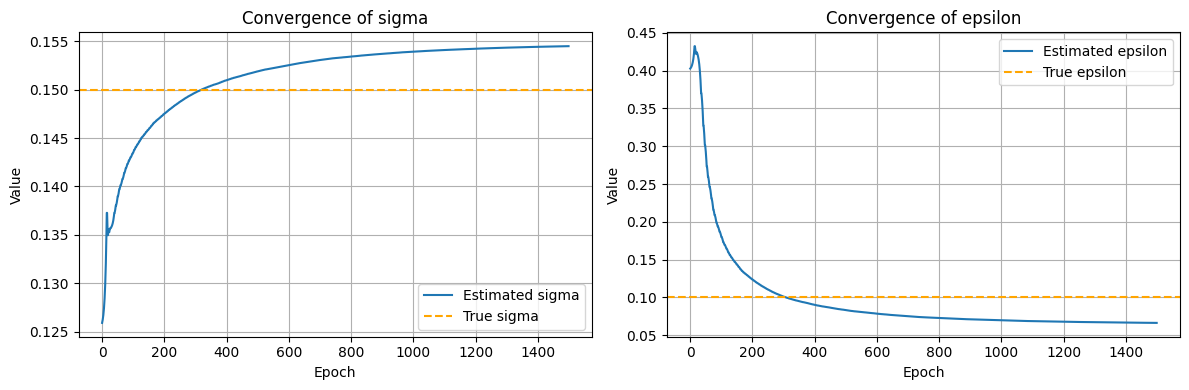

Final sigma:  0.1544938527343416
Final epsilon:  0.0621928362141545


In [17]:
def plot_param_convergence(param_history, true_params=None):
    """
    Plots the convergence of parameters over epochs.

    Args:
        param_history (dict): Dictionary where keys are parameter names and values are lists of per-epoch averages.
        true_params (dict, optional): Dictionary of true parameter values to plot as horizontal lines.
    """
    num_params = len(param_history)
    fig, axs = plt.subplots(1, num_params, figsize=(6 * num_params, 4))

    if num_params == 1:
        axs = [axs]  # Ensure axs is iterable if there's only one subplot

    for ax, (param_name, values) in zip(axs, param_history.items()):
        display_name = param_name.replace("_raw", "")  # Remove "raw" for display
        tensor_values = torch.tensor(values)

        if param_name == "sigma_raw" or param_name == "epsilon_raw" or param_name == "scale_raw" or param_name == "alpha_raw":
            ax.plot(torch.exp(tensor_values), label=f"Estimated {display_name}")
        elif param_name == "k_raw":
            ax.plot(torch.sigmoid(tensor_values), label=f"Estimated {display_name}")
        else:
            ax.plot(values, label=f"Estimated {display_name}")

        if true_params and param_name in true_params:
            ax.axhline(true_params[param_name], color='orange', linestyle='--', label=f"True {display_name}")

        ax.set_xlabel('Epoch')
        ax.set_ylabel('Value')
        ax.set_title(f'Convergence of {display_name}')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

if process == "sftcr":
    if homogeneous:
        if canonical:
            plot_param_convergence(results["param_history"], true_params={"scale_raw": scale, "gamma": sigma**(2/k)})
            print("Final gamma: ", torch.tensor(results["param_history"]["gamma"][-1]).item())
            print("True gamma: ", (sigma**(2/0.5)).item())
        else:
            plot_param_convergence(results["param_history"], true_params={"k_raw": k, "sigma_raw": sigma})
            print("Final sigma: ", torch.exp(torch.tensor(results["param_history"]["sigma_raw"][-1])).item())
            print("Final k: ", torch.sigmoid(torch.tensor(results["param_history"]["k_raw"][-1])).item())
    else:
        plot_param_convergence(results["param_history"], true_params={"scale_raw": scale, "k_raw": k, "sigma_raw": sigma})
        print("Final sigma: ", torch.exp(torch.tensor(results["param_history"]["sigma_raw"][-1])).item())
        print("Final scale: ", torch.exp(torch.tensor(results["param_history"]["scale_raw"][-1])).item())
        print("Final k: ", torch.sigmoid(torch.tensor(results["param_history"]["k_raw"][-1])).item())
else:
    if homogeneous:
        if canonical:
            plot_param_convergence(results["param_history"], true_params={"theta1": 4*epsilon*(sigma/0.1)**12, "theta2": 4*epsilon*(sigma/0.1)**6})
            print("Final theta1: ", results["param_history"]["theta1"][-1][0])
            print("True theta1: ", (4*epsilon*(sigma/0.1)**12).item())
            print("Final theta2: ", results["param_history"]["theta2"][-1][0])
            print("True theta2: ", (4*epsilon*(sigma/0.1)**6).item())
        else:
            plot_param_convergence(results["param_history"], true_params={"sigma_raw": sigma, "epsilon_raw": epsilon})
            print("Final sigma: ", torch.exp(torch.tensor(results["param_history"]["sigma_raw"][-1])).item())
            print("Final epsilon: ", torch.sigmoid(torch.tensor(results["param_history"]["epsilon_raw"][-1])).item())
    else:
        if canonical:
            plot_param_convergence(results["param_history"], true_params={"scale_raw": scale, "theta1": theta1, "theta2": theta2})
        else:
            plot_param_convergence(results["param_history"], true_params={"scale_raw": scale, "sigma_raw": sigma, "epsilon_raw": epsilon})
            print("Final sigma: ", torch.exp(torch.tensor(results["param_history"]["sigma_raw"][-1])).item())
            print("Final scale: ", torch.exp(torch.tensor(results["param_history"]["scale_raw"][-1])).item())
            print("Final epsilon: ", torch.exp(torch.tensor(results["param_history"]["epsilon_raw"][-1])).item())

## HTE Experiments

In [17]:
def json_safe(obj):
    if isinstance(obj, torch.Tensor):
        return json_safe(obj.item() if obj.numel() == 1 else obj.tolist())
    if isinstance(obj, float) and (math.isnan(obj) or math.isinf(obj)):
        return None
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, dict):
        return {k: json_safe(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [json_safe(v) for v in obj]
    return obj

In [19]:
n_repeats_widget = widgets.IntSlider(
    value=5, min=1, max=25, step=1,
    description='n_repeats:', continuous_update=False
)

K_values_widget = widgets.Text(
    value=str([None, 10, 50, 100, 200]),
    description='K values:',
    layout=widgets.Layout(width='50%')
)

epochs_widget = widgets.IntSlider(
    value=250, min=0, max=1000, step=10,
    description='Epochs:', continuous_update=False
)

canonical_widget = widgets.Checkbox(
    value=False, description='Canonical'
)

save_file_output = widgets.Text(
    value="", description='Save file:',
    layout=widgets.Layout(width='90%'),
    disabled=True
)

params = {
    "n_repeats": n_repeats_widget.value,
    "K_values": ast.literal_eval(K_values_widget.value),
    "epochs": epochs_widget.value,
    "canonical": canonical_widget.value,
    "save_file": ""
}

# Update function
def update_params(change):
    try:
        params["K_values"] = ast.literal_eval(K_values_widget.value)
    except Exception:
        params["K_values"] = None  # fallback if input is invalid

    params["n_repeats"] = n_repeats_widget.value
    params["epochs"] = epochs_widget.value
    params["canonical"] = canonical_widget.value
    if process == "lj":
        extra_params = f"_epsilon_{epsilon:.2f}_sigma_{sigma:.2f}"
    elif process == "sftcr":
        extra_params = f"_k_{k:.2f}_sigma_{sigma:.2f}"
    else:
        extra_params = ""
    
    params["save_file"] = (
        f"optimization_results_loopwise_{process}"
        f"{extra_params}"
        f"_epochs_{params['epochs']}"
        f"_canonical_{params['canonical']}.json"
    )
    save_file_output.value = params["save_file"]

# Attach observers
for w in [n_repeats_widget, K_values_widget, epochs_widget, canonical_widget]:
    w.observe(update_params, names='value')

# Initialize once
update_params(None)

# Display widgets
display(n_repeats_widget, K_values_widget, epochs_widget, canonical_widget, save_file_output)

IntSlider(value=5, continuous_update=False, description='n_repeats:', max=25, min=1)

Text(value='[None, 10, 50, 100, 200]', description='K values:', layout=Layout(width='50%'))

IntSlider(value=250, continuous_update=False, description='Epochs:', max=1000, step=10)

Checkbox(value=False, description='Canonical')

Text(value='optimization_results_loopwise_lj_epsilon_0.10_sigma_0.15_epochs_250_canonical_False.json', descrip…

In [20]:
loss_diffs = []
time_taken = []
all_processed_params = []

true_params = {}
if process == "sftcr":
    if not canonical:
        true_params.update({"k": k, "sigma": sigma})
    else:
        true_params["gamma"] = sigma**(2 / k)
    if not homogeneous:
        true_params["scale"] = scale
else:
    if not canonical:
        true_params.update({"epsilon": epsilon, "sigma": sigma})
    else:
        true_params["theta1"] = 4*epsilon*(sigma/initial_sigma)**12
        true_params["theta2"] = 4*epsilon*(sigma/initial_sigma)**6
    if not homogeneous:
        true_params["scale"] = scale

param_names = list(true_params.keys())
per_param_errors = {p: [] for p in param_names}
initial_sigma = torch.tensor(get_min_distances(samples)).mean()

loop_results = []

n_repeats = params["n_repeats"]
save_file = params["save_file"]
epochs = params["epochs"]
if os.path.exists(save_file):
    with open(save_file, "r") as f:
        file_content = json.load(f)
else:
    loop_results = []
    file_content = {
        "params": params,
        "true_params": {k: v.item() if isinstance(v, torch.Tensor) else v for k, v in true_params.items()},
        "results": []
    }

# Loop over K values
for K in params["K_values"]:
    print(f"\nRunning experiments for K = {K}")

    K_loss_diffs = []
    K_times = []
    K_processed_params = []
    K_param_errors = {p: [] for p in param_names}

    for repeat in range(n_repeats):
        print(f"  Repeat {repeat + 1}/{n_repeats}")
        start_time = time.time()
        
        results = optimize_theta(
            loader_train,
            Gibbs_Softcore if process == "sftcr" else Gibbs,
            num_epochs=epochs,
            learning_rate=1e-5,
            homogeneous=homogeneous,
            canonical=params["canonical"],
            K=K,
            initial_sigma=initial_sigma,
        )

        elapsed_time = time.time() - start_time
        K_times.append(elapsed_time)

        loss_diff = [
            l1 - l2 for l1, l2 in zip(results["avg_epoch_losses"], results["avg_epoch_real_losses"])
        ]
        avg_loss_diff = sum(loss_diff) / len(loss_diff)
        K_loss_diffs.append(avg_loss_diff)

        last_params = {p: v[-1][0] for p, v in results["param_history"].items()}
        processed_params = {}

        if "scale_raw" in last_params:
            processed_params["scale"] = np.exp(last_params["scale_raw"])
        if "sigma_raw" in last_params:
            processed_params["sigma"] = np.exp(last_params["sigma_raw"])
        if "epsilon_raw" in last_params:
            processed_params["epsilon"] = np.exp(last_params["epsilon_raw"])
        if "k_raw" in last_params:
            processed_params["k"] = 1 / (1 + np.exp(-last_params["k_raw"]))
        if "theta1" in last_params:
            processed_params["theta1"] = last_params["theta1"]
        if "theta2" in last_params:
            processed_params["theta2"] = last_params["theta2"]
        if "gamma" in last_params:
            processed_params["gamma"] = last_params["gamma"]

        K_processed_params.append(processed_params.copy())

        current_errors = {}
        for p in param_names:
            if p in processed_params:
                err = abs(processed_params[p] - true_params[p])
            else:
                err = float("nan")
            K_param_errors[p].append(err)
            current_errors[p] = err

        file_content["results"].append(json_safe({
            "K": K,
            "repeat": repeat,
            "avg_loss_diff": avg_loss_diff,
            "time_sec": elapsed_time,
            "processed_params": processed_params,
            "param_errors": current_errors,
        }))
        with open(save_file, "w") as f:
            json.dump(file_content, f, indent=2)

    avg_loss_diffs = np.mean(K_loss_diffs)
    avg_time = np.mean(K_times)
    avg_processed_params = {
        p: np.mean([d.get(p, float("nan")) for d in K_processed_params if p in d])
        for p in param_names
    }
    avg_param_errors = {
        p: np.mean([e for e in K_param_errors[p] if not np.isnan(e)])
        for p in param_names
    }

    loss_diffs.append(avg_loss_diffs)
    time_taken.append(avg_time)
    all_processed_params.append(avg_processed_params)

    print(f"  --> K={K}: avg loss diff = {avg_loss_diffs:.4f}, avg time = {avg_time:.2f}s")
    for p in param_names:
        print(f"      param {p}: avg error = {avg_param_errors[p]:.4g}")


Running experiments for K = None
  Repeat 1/5


Training: 100%|██████████| 100/100 [00:37<00:00,  2.65epoch/s, Train Loss=-1533.1459, Real Loss=-1533.1459, Time/Epoch=0.38s]


  Repeat 2/5


Training: 100%|██████████| 100/100 [00:37<00:00,  2.64epoch/s, Train Loss=-1533.1459, Real Loss=-1533.1459, Time/Epoch=0.43s]


  Repeat 3/5


Training: 100%|██████████| 100/100 [00:38<00:00,  2.60epoch/s, Train Loss=-1533.1459, Real Loss=-1533.1459, Time/Epoch=0.39s]


  Repeat 4/5


Training: 100%|██████████| 100/100 [00:38<00:00,  2.61epoch/s, Train Loss=-1533.1459, Real Loss=-1533.1459, Time/Epoch=0.38s]


  Repeat 5/5


Training: 100%|██████████| 100/100 [00:38<00:00,  2.63epoch/s, Train Loss=-1533.1459, Real Loss=-1533.1459, Time/Epoch=0.38s]


  --> K=None: avg loss diff = 0.0000, avg time = 38.08s
      param epsilon: avg error = 0.08971
      param sigma: avg error = 0.007542

Running experiments for K = 10
  Repeat 1/5


Training: 100%|██████████| 100/100 [00:03<00:00, 33.13epoch/s, Train Loss=-1587.4893, Real Loss=-1474.7663, Time/Epoch=0.03s]


  Repeat 2/5


Training: 100%|██████████| 100/100 [00:02<00:00, 33.40epoch/s, Train Loss=-1587.4893, Real Loss=-1474.7663, Time/Epoch=0.03s]


  Repeat 3/5


Training: 100%|██████████| 100/100 [00:02<00:00, 33.39epoch/s, Train Loss=-1587.4893, Real Loss=-1474.7663, Time/Epoch=0.03s]


  Repeat 4/5


Training: 100%|██████████| 100/100 [00:02<00:00, 33.81epoch/s, Train Loss=-1587.4893, Real Loss=-1474.7663, Time/Epoch=0.03s]


  Repeat 5/5


Training: 100%|██████████| 100/100 [00:02<00:00, 34.74epoch/s, Train Loss=-1587.4893, Real Loss=-1474.7663, Time/Epoch=0.03s]


  --> K=10: avg loss diff = -19.3841, avg time = 2.97s
      param epsilon: avg error = 0.3118
      param sigma: avg error = 0.01488

Running experiments for K = 50
  Repeat 1/5


Training: 100%|██████████| 100/100 [00:11<00:00,  8.97epoch/s, Train Loss=-1609.8872, Real Loss=-1500.0381, Time/Epoch=0.11s]


  Repeat 2/5


Training: 100%|██████████| 100/100 [00:11<00:00,  8.94epoch/s, Train Loss=-1609.8872, Real Loss=-1500.0381, Time/Epoch=0.10s]


  Repeat 3/5


Training: 100%|██████████| 100/100 [00:11<00:00,  8.92epoch/s, Train Loss=-1609.8872, Real Loss=-1500.0381, Time/Epoch=0.11s]


  Repeat 4/5


Training: 100%|██████████| 100/100 [00:11<00:00,  8.90epoch/s, Train Loss=-1609.8872, Real Loss=-1500.0381, Time/Epoch=0.12s]


  Repeat 5/5


Training: 100%|██████████| 100/100 [00:11<00:00,  8.88epoch/s, Train Loss=-1609.8872, Real Loss=-1500.0381, Time/Epoch=0.11s]


  --> K=50: avg loss diff = 2.8320, avg time = 11.21s
      param epsilon: avg error = 0.2268
      param sigma: avg error = 0.01282

Running experiments for K = 100
  Repeat 1/5


Training: 100%|██████████| 100/100 [00:21<00:00,  4.61epoch/s, Train Loss=-1514.1032, Real Loss=-1515.5271, Time/Epoch=0.22s]


  Repeat 2/5


Training: 100%|██████████| 100/100 [00:21<00:00,  4.63epoch/s, Train Loss=-1514.1032, Real Loss=-1515.5271, Time/Epoch=0.21s]


  Repeat 3/5


Training: 100%|██████████| 100/100 [00:21<00:00,  4.62epoch/s, Train Loss=-1514.1032, Real Loss=-1515.5271, Time/Epoch=0.21s]


  Repeat 4/5


Training: 100%|██████████| 100/100 [00:21<00:00,  4.66epoch/s, Train Loss=-1514.1032, Real Loss=-1515.5271, Time/Epoch=0.21s]


  Repeat 5/5


Training: 100%|██████████| 100/100 [00:21<00:00,  4.65epoch/s, Train Loss=-1514.1032, Real Loss=-1515.5271, Time/Epoch=0.21s]


  --> K=100: avg loss diff = 6.4507, avg time = 21.58s
      param epsilon: avg error = 0.1659
      param sigma: avg error = 0.01104

Running experiments for K = 200
  Repeat 1/5


Training: 100%|██████████| 100/100 [00:42<00:00,  2.35epoch/s, Train Loss=-1485.6907, Real Loss=-1514.2628, Time/Epoch=0.42s]


  Repeat 2/5


Training: 100%|██████████| 100/100 [00:42<00:00,  2.33epoch/s, Train Loss=-1485.6907, Real Loss=-1514.2628, Time/Epoch=0.42s]


  Repeat 3/5


Training: 100%|██████████| 100/100 [00:42<00:00,  2.33epoch/s, Train Loss=-1485.6907, Real Loss=-1514.2628, Time/Epoch=0.42s]


  Repeat 4/5


Training: 100%|██████████| 100/100 [00:42<00:00,  2.33epoch/s, Train Loss=-1485.6907, Real Loss=-1514.2628, Time/Epoch=0.43s]


  Repeat 5/5


Training: 100%|██████████| 100/100 [00:42<00:00,  2.33epoch/s, Train Loss=-1485.6907, Real Loss=-1514.2628, Time/Epoch=0.44s]

  --> K=200: avg loss diff = 4.4543, avg time = 42.84s
      param epsilon: avg error = 0.172
      param sigma: avg error = 0.01106


In [21]:
with open(save_file, "r") as f:
    data = json.load(f)

loop_results = data["results"]
true_params = data["true_params"]

# Group by K
grouped = defaultdict(list)
for entry in loop_results:
    grouped[entry["K"]].append(entry)

param_names = list(true_params.keys())

# Determine max_time for speed-up calculation
avg_times_per_K = {
    K: np.mean([r["time_sec"] for r in runs]) for K, runs in grouped.items()
}
max_time = None
for entry in loop_results:
    if entry["K"] is None:
        max_time = entry["time_sec"]
        break
if max_time is None:
    max_time = max(avg_times_per_K.values())  # fallback

rows = []
for K in sorted(grouped.keys(), key=lambda x: float("inf") if x is None else x):
    runs = grouped[K]
    avg_time = np.mean([r["time_sec"] for r in runs])
    speedup = 1.0 if K is None else round(max_time / avg_time, 2)

    avg_params = {}
    for p in param_names:
        preds = [r["processed_params"].get(p, np.nan) for r in runs]
        preds = [v for v in preds if np.isfinite(v)]
        avg_params[p] = np.mean(preds) if preds else np.nan

    row = {'K': K, 'Speed-up': speedup}
    for p in param_names:
        pred_val = avg_params.get(p, np.nan)
        true_val = true_params[p]
        # true_val might be float or int, no need to call .item() here
        row[f'{p} (true)'] = round(true_val, 8)
        row[f'{p} (pred)'] = round(pred_val, 8) if np.isfinite(pred_val) else np.nan
        if np.isfinite(pred_val) and true_val != 0:
            row[f'{p} % error'] = round((100 * abs(pred_val - true_val) / abs(true_val)), 2)
        else:
            row[f'{p} % error'] = np.nan
    rows.append(row)

df_table = pd.DataFrame(rows)
display(df_table)

,K,Speed-up,epsilon (true),epsilon (pred),epsilon % error,sigma (true),sigma (pred),sigma % error
0,10.0,12.67,0.1,0.411785,311.79,0.15,0.135125,9.92
1,50.0,3.36,0.1,0.326849,226.85,0.15,0.137177,8.55
2,100.0,1.75,0.1,0.265919,165.92,0.15,0.138965,7.36
3,200.0,0.88,0.1,0.272005,172.01,0.15,0.138940,7.37
4,NaN,1.00,0.1,0.189714,89.71,0.15,0.142458,5.03


In [33]:
with open("simulation_results/simulated_points_lj_epsilon0.1_sigma0.15_hom_results_canonical_False_initial_sigma_epoch1000.json", "r") as f:
    data = json.load(f)

param_history_dict = data["param_history"]

epsilons_raw = param_history_dict["epsilon_raw"]
sigmas_raw = param_history_dict["sigma_raw"]

# Convert string lists to floats
epsilons = [float(ast.literal_eval(e)[0]) for e in epsilons_raw]
sigmas = [float(ast.literal_eval(s)[0]) for s in sigmas_raw]

# Take 10 evenly spaced points
n = 20
indices = np.linspace(0, len(epsilons) - 1, n, dtype=int)
sampled_params = [{"epsilon_raw": np.exp(epsilons[i]), "sigma_raw": np.exp(sigmas[i])} for i in indices]

print(sampled_params)

[{'epsilon_raw': 0.06968757995444491, 'sigma_raw': 0.15391868430742814}, {'epsilon_raw': 0.06968757995444491, 'sigma_raw': 0.15391868430742814}, {'epsilon_raw': 0.06968757995444491, 'sigma_raw': 0.15391868430742814}, {'epsilon_raw': 0.06968757995444491, 'sigma_raw': 0.15391868430742814}, {'epsilon_raw': 0.06968757995444491, 'sigma_raw': 0.15391868430742814}, {'epsilon_raw': 0.06968757995444491, 'sigma_raw': 0.15391868430742814}, {'epsilon_raw': 0.06968757995444491, 'sigma_raw': 0.15391868430742814}, {'epsilon_raw': 0.06968757995444491, 'sigma_raw': 0.15391868430742814}, {'epsilon_raw': 0.06968757995444491, 'sigma_raw': 0.15391868430742814}, {'epsilon_raw': 0.06968757995444491, 'sigma_raw': 0.15391868430742814}, {'epsilon_raw': 0.06968757995444491, 'sigma_raw': 0.15391868430742814}, {'epsilon_raw': 0.06968757995444491, 'sigma_raw': 0.15391868430742814}, {'epsilon_raw': 0.06968757995444491, 'sigma_raw': 0.15391868430742814}, {'epsilon_raw': 0.06968757995444491, 'sigma_raw': 0.15391868430

## Expected number of points Experiments

In [24]:
epochs_widget = widgets.IntSlider(
    value=250, min=0, max=1000, step=10,
    description='Epochs:', continuous_update=False
)

canonical_widget = widgets.Checkbox(
    value=False, description='Canonical'
)



params = {
    "epochs": epochs_widget.value,
    "canonical": canonical_widget.value
}

# Update function
def update_params(change):
    params["epochs"] = epochs_widget.value
    params["canonical"] = canonical_widget.value

# Attach observers
for w in [epochs_widget, canonical_widget]:
    w.observe(update_params, names='value')

# Initialize once
update_params(None)

# Display widgets
display(epochs_widget, canonical_widget)

IntSlider(value=250, continuous_update=False, description='Epochs:', max=1000, step=10)

Checkbox(value=False, description='Canonical')

In [51]:
# Define your window sizes
window_sizes = torch.linspace(2.0, 0.5, steps=16)  # from -2..2 down to -1..1 in 10 steps

# Store results for each window
window_results = []

for w in window_sizes:
    print(f"\n=== Running experiments for window [-{w}, {w}] ===")

    # Crop samples to current window
    cropped_samples = []
    for s in samples:
        mask = (
            (s[:, 0] >= -w) & (s[:, 0] <= w) &
            (s[:, 1] >= -w) & (s[:, 1] <= w)
        )
        cropped_samples.append(s[mask])
    
    # Pad and prepare loaders (same logic as in your on_widget_change)
    X = pad_sequence(cropped_samples, batch_first=True, padding_value=0)
    lengths = torch.tensor([len(s) for s in cropped_samples], dtype=torch.int64, device=device)
    lengths_expanded = lengths.unsqueeze(-1).expand(-1, X.shape[1])
    X = torch.cat((X, lengths_expanded.unsqueeze(-1)), dim=-1)

    m = len(X)
    train_ratio = 1 - saved_params["test_size"]
    train_size = int(train_ratio * m)
    X_train = X[:train_size]
    X_test = X[train_size:]

    loader_train = FastTensorDataLoader(X_train, batch_size=saved_params["batch_size"], shuffle=False)
    loader_test = FastTensorDataLoader(X_test, batch_size=saved_params["batch_size"], shuffle=False)

    results = optimize_theta(
        loader_train,
        Gibbs_Softcore if process == "sftcr" else Gibbs,
        num_epochs=params["epochs"],
        learning_rate=1e-5,
        homogeneous=homogeneous,
        canonical=params["canonical"],
        K=K,
        initial_sigma=torch.tensor(get_min_distances(cropped_samples)).mean(),
    )
    
    # Collect metrics
    last_params = {p: v[-1][0] for p, v in results["param_history"].items()}
    window_results.append({
        "window": w.item() if hasattr(w, "item") else w,
        "loss": results["avg_epoch_losses"][-1],
        "params": last_params
    })

# After loop: analyze when errors blow up or loss doesn't decrease
df_window = pd.DataFrame(window_results)
display(df_window)


=== Running experiments for window [-2.0, 2.0] ===


Training: 100%|██████████| 100/100 [01:33<00:00,  1.07epoch/s, Train Loss=-248.4078, Real Loss=-248.4078, Time/Epoch=0.92s]



=== Running experiments for window [-1.9, 1.9] ===


Training: 100%|██████████| 100/100 [01:23<00:00,  1.20epoch/s, Train Loss=-242.0839, Real Loss=-242.0839, Time/Epoch=0.82s]



=== Running experiments for window [-1.8, 1.8] ===


Training: 100%|██████████| 100/100 [01:17<00:00,  1.29epoch/s, Train Loss=-237.6607, Real Loss=-237.6607, Time/Epoch=0.77s]



=== Running experiments for window [-1.7, 1.7] ===


Training: 100%|██████████| 100/100 [01:11<00:00,  1.41epoch/s, Train Loss=-233.9477, Real Loss=-233.9477, Time/Epoch=0.71s]



=== Running experiments for window [-1.6, 1.6] ===


Training: 100%|██████████| 100/100 [01:01<00:00,  1.62epoch/s, Train Loss=-226.7834, Real Loss=-226.7834, Time/Epoch=0.62s]



=== Running experiments for window [-1.5, 1.5] ===


Training: 100%|██████████| 100/100 [00:55<00:00,  1.81epoch/s, Train Loss=-220.4540, Real Loss=-220.4540, Time/Epoch=0.54s]



=== Running experiments for window [-1.4, 1.4] ===


Training: 100%|██████████| 100/100 [00:48<00:00,  2.07epoch/s, Train Loss=-234.8786, Real Loss=-234.8786, Time/Epoch=0.48s]



=== Running experiments for window [-1.3, 1.3] ===


Training: 100%|██████████| 100/100 [00:40<00:00,  2.46epoch/s, Train Loss=-252.6248, Real Loss=-252.6248, Time/Epoch=0.40s]



=== Running experiments for window [-1.2, 1.2] ===


Training: 100%|██████████| 100/100 [00:33<00:00,  2.95epoch/s, Train Loss=-251.7990, Real Loss=-251.7990, Time/Epoch=0.34s]



=== Running experiments for window [-1.1, 1.1] ===


Training: 100%|██████████| 100/100 [00:28<00:00,  3.53epoch/s, Train Loss=-250.0785, Real Loss=-250.0785, Time/Epoch=0.28s]



=== Running experiments for window [-1.0, 1.0] ===


Training: 100%|██████████| 100/100 [00:23<00:00,  4.25epoch/s, Train Loss=-240.3771, Real Loss=-240.3771, Time/Epoch=0.23s]



=== Running experiments for window [-0.9, 0.9] ===


Training: 100%|██████████| 100/100 [00:19<00:00,  5.12epoch/s, Train Loss=-217.8213, Real Loss=-217.8213, Time/Epoch=0.19s]



=== Running experiments for window [-0.8, 0.8] ===


Training: 100%|██████████| 100/100 [00:16<00:00,  5.94epoch/s, Train Loss=-212.0519, Real Loss=-212.0519, Time/Epoch=0.16s]



=== Running experiments for window [-0.7, 0.7] ===


Training: 100%|██████████| 100/100 [00:12<00:00,  8.31epoch/s, Train Loss=-180.2751, Real Loss=-180.2751, Time/Epoch=0.12s]



=== Running experiments for window [-0.6, 0.6] ===


Training: 100%|██████████| 100/100 [00:09<00:00, 10.90epoch/s, Train Loss=-14266202.9497, Real Loss=-14266202.9497, Time/Epoch=0.09s]



=== Running experiments for window [-0.5, 0.5] ===


Training: 100%|██████████| 100/100 [00:07<00:00, 14.14epoch/s, Train Loss=-3234283.3175, Real Loss=-3234283.3175, Time/Epoch=0.07s]


,window,loss,params
0,2.0,-2.484078e+02,"{'sigma_raw': -1.8972682066204358, 'k_raw': -0..."
1,1.9,-2.420839e+02,"{'sigma_raw': -1.8821091405034662, 'k_raw': -0..."
2,1.8,-2.376607e+02,"{'sigma_raw': -1.8872995378516544, 'k_raw': -0..."
3,1.7,-2.339477e+02,"{'sigma_raw': -1.8929776291472555, 'k_raw': 0...."
4,1.6,-2.267834e+02,"{'sigma_raw': -1.913567508147337, 'k_raw': -0...."
5,1.5,-2.204540e+02,"{'sigma_raw': -1.9060028530969628, 'k_raw': 0...."
6,1.4,-2.348786e+02,"{'sigma_raw': -1.9332064444469015, 'k_raw': -0..."
7,1.3,-2.526248e+02,"{'sigma_raw': -1.95744996490508, 'k_raw': -0.3..."
8,1.2,-2.517990e+02,"{'sigma_raw': -1.9695549293074563, 'k_raw': -0..."
9,1.1,-2.500785e+02,"{'sigma_raw': -1.9903190080909645, 'k_raw': -0..."


In [52]:
avg_points_full = np.mean([len(s) for s in samples])

expected_points = []
for w in window_sizes:
    area_ratio = ((2 * w) ** 2) / ((2 * 2) ** 2)  # (window area) / (full area)
    N_expected_avg = avg_points_full * area_ratio
    expected_points.append({
        "window": float(w),
        "expected_avg_points": N_expected_avg.item()
    })

df_expected = pd.DataFrame(expected_points)

In [54]:
params_df = pd.json_normalize(df_window['params'])

# Transform sigma_raw and k_raw
params_df['sigma'] = params_df['sigma_raw'].apply(lambda x: float(torch.exp(torch.tensor(x))))
params_df['k'] = params_df['k_raw'].apply(lambda x: float(torch.sigmoid(torch.tensor(x))))

# Drop raw columns
params_df = params_df.drop(columns=['sigma_raw', 'k_raw'], errors='ignore')

# Concatenate with original df_window
df_window_expanded = pd.concat([df_window.drop(columns=['params']), params_df, df_expected], axis=1)

# Add true values
df_window_expanded['true_sigma'] = sigma.item()
df_window_expanded['true_k'] = k.item()

# Calculate relative errors in %
df_window_expanded['sigma_error_%'] = 100 * (df_window_expanded['sigma'] - sigma.item()).abs() / sigma.item()
df_window_expanded['k_error_%'] = 100 * (df_window_expanded['k'] - k.item()).abs() / k.item()

display(df_window_expanded)

,window,loss,sigma,k,window,expected_avg_points,true_sigma,true_k,sigma_error_%,k_error_%
0,2.0,-2.484078e+02,0.149978,0.477998,2.0,201.4000,0.15,0.5,0.014821,4.400462
1,1.9,-2.420839e+02,0.152269,0.497184,1.9,181.7635,0.15,0.5,1.512407,0.563286
2,1.8,-2.376607e+02,0.151480,0.499211,1.8,163.1340,0.15,0.5,0.986883,0.157721
3,1.7,-2.339477e+02,0.150623,0.502005,1.7,145.5115,0.15,0.5,0.415095,0.401013
4,1.6,-2.267834e+02,0.147553,0.493179,1.6,128.8960,0.15,0.5,1.631300,1.364210
5,1.5,-2.204540e+02,0.148673,0.510062,1.5,113.2875,0.15,0.5,0.884353,2.012431
6,1.4,-2.348786e+02,0.144684,0.446381,1.4,98.6860,0.15,0.5,3.544311,10.723850
7,1.3,-2.526248e+02,0.141218,0.402959,1.3,85.0915,0.15,0.5,5.854618,19.408153
8,1.2,-2.517990e+02,0.139519,0.395090,1.2,72.5040,0.15,0.5,6.987375,20.982061
9,1.1,-2.500785e+02,0.136652,0.383136,1.1,60.9235,0.15,0.5,8.898783,23.372753
